<h1><center><font color='blue'><h1>DATA EXPLORATORY ANALYSIS AND HYPOTHESIS<h1></font></center></h1>

<h1><center>TESTING FOR INSURANCE CLAIMS DATA</center></h1> 

#### Q1. Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import re
import scipy.stats as stats
# set the graphs to show in the jupyter notebook
%matplotlib inline

# set seabor graphs to a better style
sns.set(style="ticks")

In [3]:
claims=pd.read_csv('claims.csv')
claims

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes
3,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No
4,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1.0,No
...,...,...,...,...,...,...,...,...,...,...
1095,97727122,35951012,Other driver error,06/11/2017,Auto,No,Material only,$3059,4.0,Yes
1096,10247193,14818669,Natural causes,03/14/2018,Auto,No,Material only,$1520,2.0,No
1097,79807493,85322831,Other driver error,02/09/2018,Auto,No,Material and injury,$23575,2.0,Yes
1098,69299345,73449366,Other causes,03/21/2018,Auto,Unknown,Material and injury,$25120,1.0,No


In [4]:
cust=pd.read_csv('cust_demographics.csv')
cust

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,01-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold
...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver


In [5]:
Cust_claims= claims.merge(cust, left_on=['customer_id'], right_on=['CUST_ID'], how='inner')
Cust_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   claim_id             1085 non-null   int64  
 1   customer_id          1085 non-null   int64  
 2   incident_cause       1085 non-null   object 
 3   claim_date           1085 non-null   object 
 4   claim_area           1085 non-null   object 
 5   police_report        1085 non-null   object 
 6   claim_type           1085 non-null   object 
 7   claim_amount         1020 non-null   object 
 8   total_policy_claims  1075 non-null   float64
 9   fraudulent           1085 non-null   object 
 10  CUST_ID              1085 non-null   int64  
 11  gender               1085 non-null   object 
 12  DateOfBirth          1085 non-null   object 
 13  State                1085 non-null   object 
 14  Contact              1085 non-null   object 
 15  Segment              1085 non-null   o

#### Q2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance.

In [6]:
Cust_claims.head(2)

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No,75740424,Female,13-Jan-70,ME,265-543-1264,Silver


In [7]:
numeric_columns = Cust_claims.select_dtypes(include = ['float64', 'int64'])
object_columns = Cust_claims.select_dtypes(include = ['object'])

In [8]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [9]:
def categorical_var_summary( x ):
    
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100 / x.count(), 2)], 
                     
                  index = ['n', 'nmiss', 'MODE', 'FREQ', 'PERCENT'])

In [10]:
numeric_audit=numeric_columns.apply( lambda x: continuous_var_summary(x))
numeric_audit

,claim_id,customer_id,total_policy_claims,CUST_ID
dtype,int64,int64,float64,int64
cardinality,1085,1078,8,1078
n_tot,1085,1085,1085,1085
n,1085,1085,1075,1085
nmiss,0,0,10,0
perc_miss,0.0,0.0,0.921659,0.0
sum,53073348315,55083176211,1706.0,55083176211
mean,48915528.400922,50767904.341935,1.586977,50767904.341935
std,29128181.617819,28496245.372373,1.146859,28496245.372373
var,848450964360648.625,812036000322492.625,1.315286,812036000322492.625


##### There are id variables and total_policy_claims only which can be processed as per the given data, it requires data type conversions to proper format

In [11]:
categorical_audit= object_columns.apply( lambda x: categorical_var_summary(x))
categorical_audit

,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,fraudulent,gender,DateOfBirth,State,Contact,Segment
n,1085,1085,1085,1085,1085,1020,1085,1085,1085,1085,1085,1085
nmiss,0,0,0,0,0,65,0,0,0,0,0,0
MODE,Other causes,04/04/2018,Auto,No,Material only,$2320,No,Male,18-Oct-72,NY,743-569-4783,Gold
FREQ,285,18,970,621,653,7,838,556,2,31,2,375
PERCENT,26.27,1.66,89.4,57.24,60.18,0.69,77.24,51.24,0.18,2.86,0.18,34.56


### The amount variables, date variables shall be changed to proper formats, contact variable has no business significance for the analysis.

#### Data type conversions for variables which are not of proper type

claim_date, claim_amount ($, datatype), DateOfBirth)

In [12]:
Cust_claims["DateOfBirth"] = pd.to_datetime(Cust_claims.DateOfBirth, format = "%d-%b-%y")
Cust_claims.loc[(Cust_claims.DateOfBirth.dt.year > 2020),"DateOfBirth"]=Cust_claims[Cust_claims.DateOfBirth.dt.year > 2020]["DateOfBirth"].apply(lambda x: x - pd.DateOffset(years=100))


In [13]:
print(Cust_claims["DateOfBirth"].head())

0   1979-01-12
1   1970-01-13
2   1984-03-11
3   1984-03-11
4   1986-05-01
Name: DateOfBirth, dtype: datetime64[ns]


In [14]:
Cust_claims["claim_date"] = pd.to_datetime(Cust_claims.claim_date, format = "%m/%d/%Y")

In [15]:
print(Cust_claims["claim_date"].head())

0   2017-11-27
1   2018-10-03
2   2018-02-02
3   2018-04-04
4   2018-06-17
Name: claim_date, dtype: datetime64[ns]


#### Q3 Convert the column claim_amount to numeric. Use the appropriate modules/attributes to remove the $ sign

In [16]:
Cust_claims["claim_amount"]= Cust_claims['claim_amount'].astype(str)
Cust_claims['claim_amount'] = Cust_claims['claim_amount'].str.replace('$','')
Cust_claims['claim_amount']= np.where(Cust_claims.claim_amount== "nan","",Cust_claims.claim_amount )

In [17]:
print("Data type of 'claim_amount' column after conversion:", Cust_claims["claim_amount"].dtype)

Data type of 'claim_amount' column after conversion: object


In [18]:
Cust_claims['claim_amount'] = pd.to_numeric(Cust_claims['claim_amount'])
np.dtype(Cust_claims.claim_amount)

dtype('float64')

#### Q4. Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims

In [19]:
Cust_claims['unreported_claims']= np.where(Cust_claims.police_report== 'Unknown',1,0)
Cust_claims.head(10)

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment,unreported_claims
0,54004764,21868593,Driver error,2017-11-27,Auto,No,Material only,2980.0,1.0,No,21868593,Female,1979-01-12,VT,789-916-8172,Platinum,0
1,33985796,75740424,Crime,2018-10-03,Home,Unknown,Material only,2980.0,3.0,No,75740424,Female,1970-01-13,ME,265-543-1264,Silver,1
2,53522022,30308357,Other driver error,2018-02-02,Auto,No,Material only,3369.5,1.0,Yes,30308357,Female,1984-03-11,TN,798-631-4758,Silver,0
3,63017412,30308357,Driver error,2018-04-04,Auto,No,Material only,1950.0,6.0,No,30308357,Female,1984-03-11,TN,798-631-4758,Silver,0
4,13015401,47830476,Natural causes,2018-06-17,Auto,No,Material only,1680.0,1.0,No,47830476,Female,1986-05-01,MA,413-187-7945,Silver,0
5,91609100,47830476,Natural causes,2017-04-12,Auto,Unknown,Material only,1440.0,1.0,No,47830476,Female,1986-05-01,MA,413-187-7945,Silver,1
6,22890252,19269962,Crime,2018-01-13,Auto,No,Material only,2680.0,1.0,No,19269962,Male,1977-05-13,NV,956-871-8691,Gold,0
7,39219616,19269962,Other causes,2018-09-26,Auto,No,Material only,2240.0,2.0,No,19269962,Male,1977-05-13,NV,956-871-8691,Gold,0
8,24050443,21831191,Other driver error,2017-10-04,Auto,No,Injury only,38306.5,3.0,Yes,21831191,Male,1977-05-17,NH,419-712-8513,Gold,0
9,91475471,21831191,Driver error,2018-02-09,Auto,Unknown,Material and injury,36810.0,1.0,No,21831191,Male,1977-05-17,NH,419-712-8513,Gold,1


#### Q5. One customer can claim for insurance more than once and in each claim,multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.

In [20]:
Cust_claims= Cust_claims.drop_duplicates(subset="customer_id", keep= "last")

In [21]:
duplicated_customer_ids = Cust_claims.duplicated(subset="customer_id", keep=False)
print("Number of duplicate customer IDs after dropping duplicates:", sum(duplicated_customer_ids))

Number of duplicate customer IDs after dropping duplicates: 0


In [22]:
# Verify the data
unique_customer_ids = Cust_claims["customer_id"].unique()
print("Number of unique customer IDs:", len(unique_customer_ids))

Number of unique customer IDs: 1078


In [23]:
# Ensure each customer ID appears only once
if len(unique_customer_ids) == len(Cust_claims):
    print("Each customer ID appears only once in the dataset.")
else:
    print("There are still duplicated customer IDs in the dataset.")

Each customer ID appears only once in the dataset.


#### Q6. Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [24]:
Cust_claims.isna().sum()

claim_id                0
customer_id             0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
CUST_ID                 0
gender                  0
DateOfBirth             0
State                   0
Contact                 0
Segment                 0
unreported_claims       0
dtype: int64

In [25]:
print(Cust_claims['claim_amount'].unique())

[ 2980.   1950.   1440.   2240.  36810.   1730.   1160.   2620.   2748.5
  1495.  16690.   1870.   1050.  32560.   2870.   3208.5 17800.  31380.
 36190.      nan  1010.  16830.   1690.   2830.  32640.   1210.  18580.
  2630.   2540.   2320.   2725.5  2070.   1110.   1030.  16910.   1890.
 33040.  25320.   2340.  33000.  19960.  27230.  16150.  32630.  41850.
 30540.  25576.   2210.  40820.   1150.  35765.   2470.  20999.   3358.
 41430.  20360.   2910.  33550.  33190.  25830.   1242.  20080.   2120.
 19520.   2090.   1989.5  2060.  30080.   1680.  21505.   2040.  42722.5
 34971.5  1288.  37800.   1180.  32480.   2710.   1943.5  2170.  31498.5
  1700.   2220.   1020.   1400.  22960.  18400.  37524.5 16070.  17230.
 24564.   2599.  23740.   1510.   2740.  23760.   1640.  23270.  29060.
 25783.  36620.  21300.   2967.  44493.5  3070.5  2560.   1759.5  1771.
 17360.   1368.5 19240.  14260.   1350.   1860.  15440.  32710.   1380.
  2510.  44700.5  1550.   1850.   2760.  26480.  47610.  1759

In [26]:
# Attempt to convert 'claim_amount' column to numeric
Cust_claims['claim_amount'] = pd.to_numeric(Cust_claims['claim_amount'], errors='coerce')

# Check if there are any non-numeric values left after coercion
print(Cust_claims['claim_amount'].isna().sum())

# Impute missing values with mean
Cust_claims['claim_amount'].fillna(Cust_claims['claim_amount'].mean(), inplace=True)

65


In [27]:
Cust_claims["claim_amount"]= Cust_claims['claim_amount'].replace(np.NaN,Cust_claims['claim_amount'].mean())
Cust_claims["claim_amount"].isna().sum()

0

In [28]:
Cust_claims.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1078 entries, 0 to 1084
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   claim_id             1078 non-null   int64         
 1   customer_id          1078 non-null   int64         
 2   incident_cause       1078 non-null   object        
 3   claim_date           1078 non-null   datetime64[ns]
 4   claim_area           1078 non-null   object        
 5   police_report        1078 non-null   object        
 6   claim_type           1078 non-null   object        
 7   claim_amount         1078 non-null   float64       
 8   total_policy_claims  1068 non-null   float64       
 9   fraudulent           1078 non-null   object        
 10  CUST_ID              1078 non-null   int64         
 11  gender               1078 non-null   object        
 12  DateOfBirth          1078 non-null   datetime64[ns]
 13  State                1078 non-null   o

In [29]:
Cust_claims["total_policy_claims"] = Cust_claims['total_policy_claims'].fillna(Cust_claims['total_policy_claims'].mode()[0])

In [30]:
Cust_claims["total_policy_claims"]= Cust_claims["total_policy_claims"].astype(str)

In [31]:
Cust_claims["total_policy_claims"].isna().sum()

0

#### Q7. Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteria 
###### Children < 18 
###### Youth 18-30 
###### Adult 30-60 
###### Senior > 60

In [32]:
curr_year = pd.to_datetime('today').year
dob_year = pd.DatetimeIndex(Cust_claims['DateOfBirth']).year          #extract year from DateOfBirth
x = dob_year-100                                               # for the years which belongs to 60's
v = curr_year - x
y = curr_year - dob_year
Cust_claims['age'] = (np.where(dob_year > curr_year,v,y))
#Categorising
Cust_claims.loc[(Cust_claims.age < 18),'AgeGroup'] = 'Children'
Cust_claims.loc[(Cust_claims.age >=18) & (Cust_claims.age <30),'AgeGroup'] = 'Youth'
Cust_claims.loc[(Cust_claims.age >=30) & (Cust_claims.age <60),'AgeGroup'] = 'Adult'
Cust_claims.loc[(Cust_claims.age >=60),'AgeGroup'] = 'Senior'

In [33]:
Cust_claims.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment,unreported_claims,age,AgeGroup
0,54004764,21868593,Driver error,2017-11-27,Auto,No,Material only,2980.0,1.0,No,21868593,Female,1979-01-12,VT,789-916-8172,Platinum,0,45,Adult
1,33985796,75740424,Crime,2018-10-03,Home,Unknown,Material only,2980.0,3.0,No,75740424,Female,1970-01-13,ME,265-543-1264,Silver,1,54,Adult
3,63017412,30308357,Driver error,2018-04-04,Auto,No,Material only,1950.0,6.0,No,30308357,Female,1984-03-11,TN,798-631-4758,Silver,0,40,Adult
5,91609100,47830476,Natural causes,2017-04-12,Auto,Unknown,Material only,1440.0,1.0,No,47830476,Female,1986-05-01,MA,413-187-7945,Silver,1,38,Adult
7,39219616,19269962,Other causes,2018-09-26,Auto,No,Material only,2240.0,2.0,No,19269962,Male,1977-05-13,NV,956-871-8691,Gold,0,47,Adult


In [34]:
Cust_claims.groupby(["AgeGroup"])["age"].count()

AgeGroup
Adult     805
Senior    132
Youth     141
Name: age, dtype: int64

#### Q8. What is the average amount claimed by the customers from various segments?

In [35]:
Avg_amount_segment= round(Cust_claims.groupby(["Segment"])["claim_amount"].mean(),2)
Avg_amount_segment

Segment
Gold        12846.39
Platinum    12371.64
Silver      12267.15
Name: claim_amount, dtype: float64

#### Q9. What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [36]:
Amount_incedent= round(Cust_claims.loc[Cust_claims.claim_date < "2018-09-10",:].groupby("incident_cause")["claim_amount"].sum().add_prefix("total_"),2)
Amount_incedent

incident_cause
total_Crime                  721937.45
total_Driver error          3315847.88
total_Natural causes        1312744.91
total_Other causes          3723147.30
total_Other driver error    3277533.37
Name: claim_amount, dtype: float64

#### Q10. How many adults from TX, DE and AK claimed insurance for driver related issues and causes?

In [37]:
Cust_claims.columns

Index(['claim_id', 'customer_id', 'incident_cause', 'claim_date', 'claim_area',
       'police_report', 'claim_type', 'claim_amount', 'total_policy_claims',
       'fraudulent', 'CUST_ID', 'gender', 'DateOfBirth', 'State', 'Contact',
       'Segment', 'unreported_claims', 'age', 'AgeGroup'],
      dtype='object')

In [38]:
Adults_claims_count= Cust_claims.loc[(Cust_claims.incident_cause.str.lower().str.contains("driver") & (Cust_claims.State== "TX") | (Cust_claims.State== "DE") | (Cust_claims.State== "AK")) ].groupby(["State"])["claim_amount"].count()
Adults_claims_count

State
AK    19
DE    29
TX    10
Name: claim_amount, dtype: int64

#### Q11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.

In [39]:
Claim_gender_segment= round(Cust_claims.groupby(["Segment", "gender"])["claim_amount"].sum().reset_index(),2)
Claim_gender_segment

,Segment,gender,claim_amount
0,Gold,Female,2110042.41
1,Gold,Male,2655966.87
2,Platinum,Female,2369720.43
3,Platinum,Male,2096443.42
4,Silver,Female,1897301.87
5,Silver,Male,2347130.84


In [40]:
Claim_gender_segment_pivot= Claim_gender_segment.pivot(index="Segment", columns= "gender", values= "claim_amount")
Claim_gender_segment_pivot

gender,Female,Male
Segment,,
Gold,2110042.41,2655966.87
Platinum,2369720.43,2096443.42
Silver,1897301.87,2347130.84


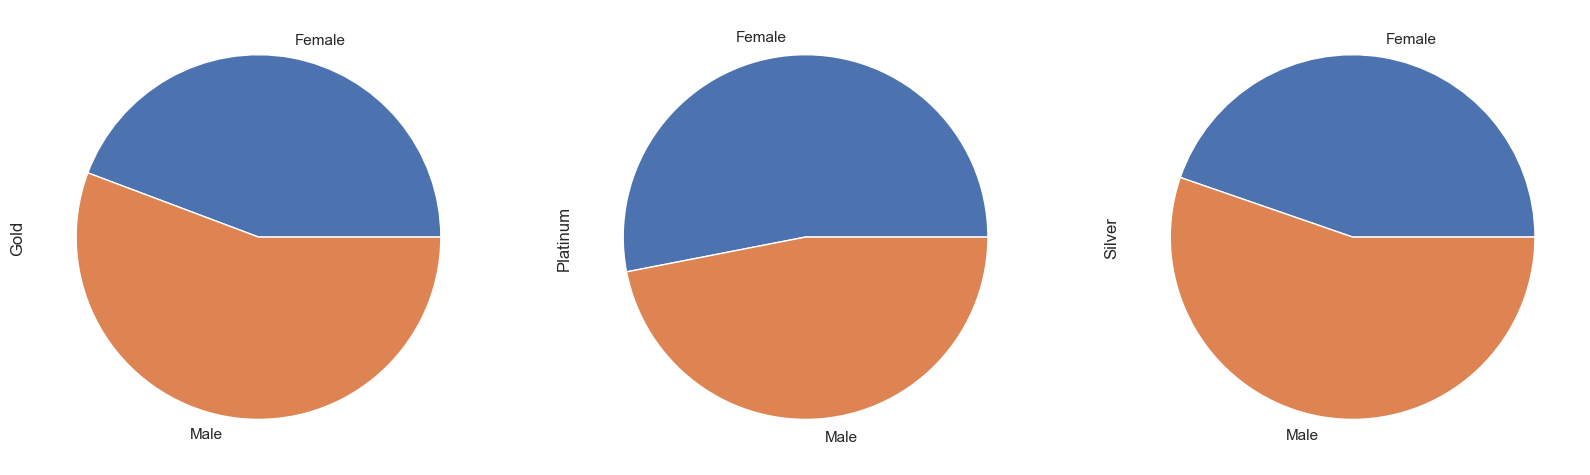

In [41]:
Claim_gender_segment_pivot.T.plot(kind="pie", subplots= True, legend= False,figsize=(20,10))
plt.show()

#### Q12. Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart

In [42]:
Claim_gender_driver= Cust_claims.loc[(Cust_claims.incident_cause.str.lower().str.contains("driver"))].groupby(["gender"])[["gender"]].count().add_prefix("countOf_").reset_index()
Claim_gender_driver

,gender,countOf_gender
0,Female,221
1,Male,281


[]

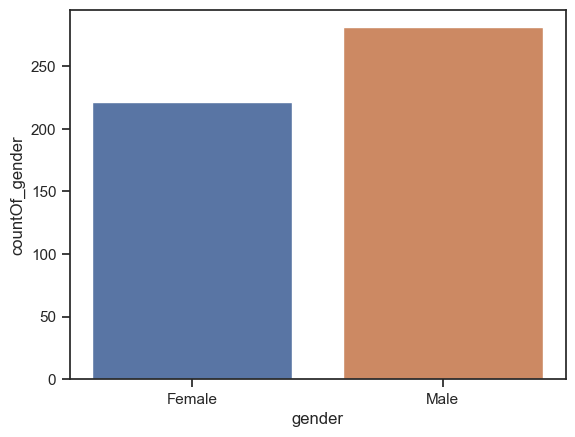

In [43]:
sns.barplot(x= "gender", y= "countOf_gender", data= Claim_gender_driver)
plt.plot()

#### Q13. Which age group had the maximum fraudulent policy claims? Visualize it on a bar char

In [44]:
Cust_claims["Frauds"]= np.where(Cust_claims.fraudulent == "Yes",1,0)

In [45]:
AgeGroup_max_frauds= Cust_claims.groupby(["AgeGroup"])["Frauds"].sum().reset_index()
AgeGroup_max_frauds

,AgeGroup,Frauds
0,Adult,185
1,Senior,35
2,Youth,25


[]

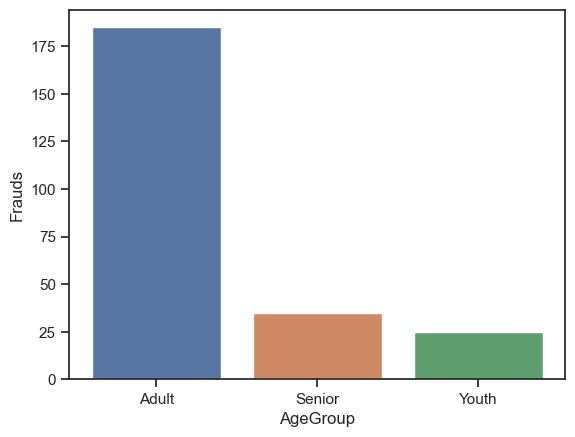

In [46]:
sns.barplot(x= "AgeGroup", y="Frauds", data=AgeGroup_max_frauds )
plt.plot()

#### Q14. Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.

In [47]:
Cust_claims['claim_month'] = pd.to_datetime(Cust_claims['claim_date'])
Cust_claims['Claim_month'] = Cust_claims['claim_month'].dt.month

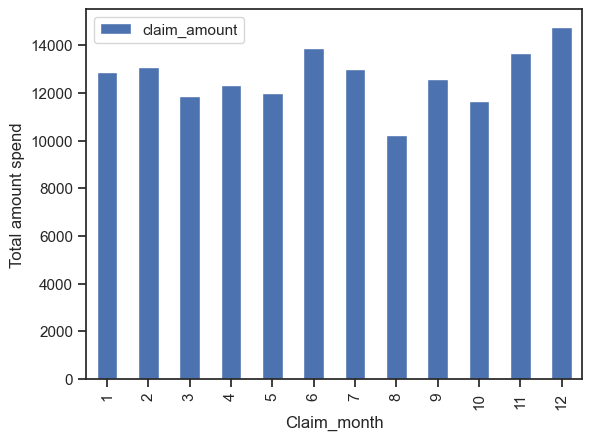

In [48]:
pd.pivot_table(Cust_claims,index="Claim_month",values="claim_amount").plot(kind='bar')
plt.ylabel('Total amount spend')
plt.show()

#### Q15. What is the average claim amount for gender and age categories and suitably represent the above using a facetted bar chart, one facet that represents fraudulent claims and the other for non-fraudulent claims.

In [49]:
Frauds_amount_gender= pd.DataFrame(Cust_claims.loc[(Cust_claims.fraudulent=="Yes")].groupby(["gender","AgeGroup"])[["claim_amount"]].mean().add_prefix("Fraud_"))
Non_Frauds_amount_gender=pd.DataFrame(Cust_claims.loc[(Cust_claims.fraudulent=="No")].groupby(["gender","AgeGroup"])[["claim_amount"]].mean().add_prefix("Non_Fraud_"))

In [50]:
Claims_age_gender=round(pd.merge(Frauds_amount_gender,Non_Frauds_amount_gender, on=["gender","AgeGroup"]),2)
Claims_age_gender

Fraud_claim_amount  Non_Fraud_claim_amount
gender AgeGroup                                            
Female Adult               12916.53                12708.93
       Senior               4860.84                11588.84
       Youth                9684.78                11374.34
Male   Adult               15383.11                12221.90
       Senior              15424.15                11569.11
       Youth                9705.04                13596.12

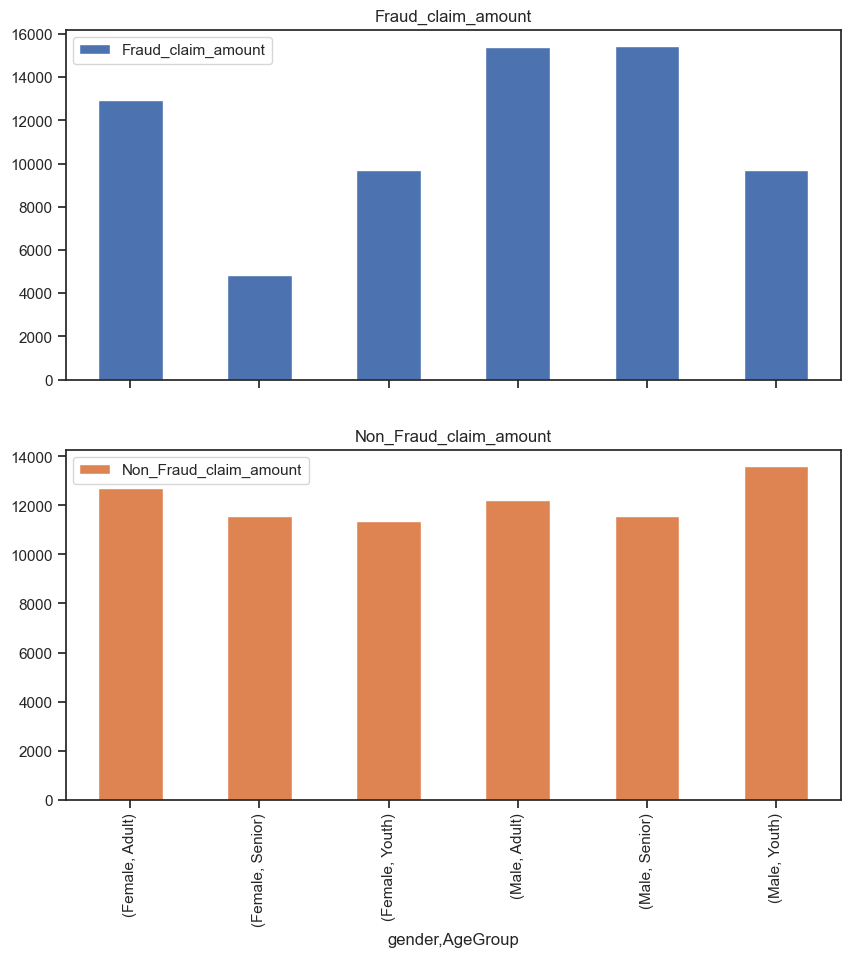

In [51]:
Claims_age_gender.plot(kind="bar", subplots= True, legend= True,figsize=(10,10))
plt.show()

#### Based on the conclusions from exploratory analysis as well as suitable statistical tests, answer the below questions. Please include a detailed write-up on the parameters taken into consideration, the Hypothesis testing steps, conclusion from the p-values and the business implications of the statements.

#### Q16. Is there any similarity in the amount claimed by males and females?¶

In [52]:
claim_male = Cust_claims['claim_amount'].loc[Cust_claims['gender']=="Male"]
claim_female = Cust_claims['claim_amount'].loc[Cust_claims['gender']=="Female"]

In [53]:
print("The average amount claimed by males is {}".format(claim_male.mean()))

print("The average amount claimed by females is {}".format(claim_female.mean()))

The average amount claimed by males is 12884.829631308417
The average amount claimed by females is 12100.692029236623


In [54]:
#checking the variance

eq_var = stats.ttest_ind(a= claim_male,
                b= claim_female,
                equal_var=True)    # equal variance
eq_var.statistic

0.9630529881732579

In [55]:
uneq_var = stats.ttest_ind(a= claim_male,
                b= claim_female,
                equal_var=False)    # UnEqual variance
uneq_var.statistic

0.9637241707490979

In [56]:
t= eq_var.statistic
p= eq_var.pvalue

print(" For the above test, the t-score is {} and the p-value is {}".format(t,p))

if(p<0.05):
    print('We reject null hypothesis')
else:
    print('We fail to reject null hypothesis')

 For the above test, the t-score is 0.9630529881732579 and the p-value is 0.3357373087404283
We fail to reject null hypothesis


##### As the significance value of t test is greater than 0.05 we can safely conclude that there is a similarity in amount claimed by males and females.

#### Q17. Is there any relationship between age category and segment?

In [57]:
agecat_seg = pd.crosstab(Cust_claims.AgeGroup, Cust_claims.Segment, margins = True)
agecat_seg

Segment,Gold,Platinum,Silver,All
AgeGroup,,,,
Adult,278,270,257,805
Senior,45,47,40,132
Youth,48,44,49,141
All,371,361,346,1078


In [58]:
Chi_test = stats.chi2_contingency(observed= agecat_seg)
Chi_test

Chi2ContingencyResult(statistic=0.8591966330667935, pvalue=0.9996992437870238, dof=9, expected_freq=array([[ 277.04545455,  269.57792208,  258.37662338,  805.        ],
       [  45.42857143,   44.20408163,   42.36734694,  132.        ],
       [  48.52597403,   47.21799629,   45.25602968,  141.        ],
       [ 371.        ,  361.        ,  346.        , 1078.        ]]))

In [59]:
print("The chi square stat is {} and the p value is {}".format(Chi_test[0],Chi_test[1]))

The chi square stat is 0.8591966330667935 and the p value is 0.9996992437870238


##### Since the significance value of the test is greter than 0.05, we fail reject the null hypothesis. Therefore there is no relationship between age category and segment

#### Q18. The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.

In [60]:
# Create Year column
Cust_claims['claim_year']=Cust_claims['claim_date'].dt.year

Cust_claims['claim_year']=Cust_claims['claim_year'].astype('Int64')

In [61]:
# Get the current year (latest) from the data
Cust_claims.claim_year.max()

2018

In [62]:
Cust_claims[Cust_claims.claim_year==2018][['claim_amount']]

,claim_amount
1,2980.0
3,1950.0
7,2240.0
9,36810.0
10,1730.0
...,...
1073,2730.0
1074,33330.0
1075,2780.0
1077,2290.0


In [63]:
current_year_claim=Cust_claims.loc[Cust_claims.claim_year == 2018]["claim_amount"]
claim_year_2017=Cust_claims.loc[Cust_claims.claim_year == 2017]["claim_amount"]

In [64]:
current_year_claim

1        2980.0
3        1950.0
7        2240.0
9       36810.0
10       1730.0
         ...   
1073     2730.0
1074    33330.0
1075     2780.0
1077     2290.0
1080     1770.0
Name: claim_amount, Length: 484, dtype: float64

In [65]:
claim_year_2017

0        2980.0
5        1440.0
13       2748.5
15      16690.0
21      17800.0
         ...   
1079     2173.5
1081     2800.0
1082    33080.0
1083     2840.0
1084     1490.0
Name: claim_amount, Length: 594, dtype: float64

In [66]:
print("fiscal average of current " , round(current_year_claim.mean()))
print("fiscal average of year 2016-2017 ",round(claim_year_2017.mean()))

fiscal average of current  12766
fiscal average of year 2016-2017  12286


### These are independent data set. thus, we will perform the independent T-Test

In [67]:
check_stats=stats.ttest_ind(current_year_claim,claim_year_2017)
check_stats

TtestResult(statistic=0.5870950089734058, pvalue=0.5572630625953376, df=1076.0)

In [68]:
p=check_stats.pvalue
if(p<0.05):
    print('We reject null hypothesis')
else:
    print('We fail to reject null hypothesis')

We fail to reject null hypothesis


#### Thus , There is no significat increase in claim amount in current year as compared to 2016-17.

#### 19. Is there any difference between age groups and insurance claims?

#### Here we will perform Ftest ANOVA

In [69]:
age_group_1 = Cust_claims['total_policy_claims'].loc[Cust_claims['AgeGroup']=="Youth"]
age_group_2 = Cust_claims['total_policy_claims'].loc[Cust_claims['AgeGroup']=="Adult"]
# Perfrom the Anova
anova = stats.f_oneway(age_group_1,age_group_2)
# Statistic :  F Value
f = anova.statistic
p = anova.pvalue
print("The f-value is {} and the p value is {}".format(f,p))
if(p<0.05):
    print('We reject null hypothesis')
else:
    print('We fail to reject null hypothesis')

The f-value is 0.7257860470318822 and the p value is 0.39446858447695
We fail to reject null hypothesis


#### Q 20. Is there any relationship between total number of policy claims and the claimed amount?

In [71]:
Cust_claims.total_policy_claims

0       1.0
1       3.0
3       6.0
5       1.0
7       2.0
       ... 
1080    1.0
1081    1.0
1082    2.0
1083    4.0
1084    1.0
Name: total_policy_claims, Length: 1078, dtype: float64

In [72]:
Cust_claims.claim_amount

0        2980.0
1        2980.0
3        1950.0
5        1440.0
7        2240.0
         ...   
1080     1770.0
1081     2800.0
1082    33080.0
1083     2840.0
1084     1490.0
Name: claim_amount, Length: 1078, dtype: float64

In [73]:
Cust_claims['total_policy_claims'] = pd.to_numeric(Cust_claims['total_policy_claims'], errors='coerce')
Cust_claims['claim_amount'] = pd.to_numeric(Cust_claims['claim_amount'].replace('[\$,]', '', regex=True), errors='coerce')

In [74]:
Cust_claims.dropna(subset=['total_policy_claims', 'claim_amount'], inplace=True)

In [75]:
corr, p_value = stats.pearsonr(Cust_claims['total_policy_claims'], Cust_claims['claim_amount'])
print("Pearson correlation coefficient:", corr)
print("p-value:", p_value)

Pearson correlation coefficient: -0.02239272073209991
p-value: 0.4626700742271313


##### Based on ANOVA Test results we can observe that the p-Value is higher than the decided p-Value of 0.05. So we accept the null hypothesis. Thus, we can say that there is no difference in average claim amount for total number of claims and hence there is no relationship